<a href="https://colab.research.google.com/github/mamoan/NOVA_DL_home_exercise/blob/main/2_UTM_to_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2 - Convert from geographical space to image space     🗺️ --> 🖼️
## OBJECTIVE:  converting the bounding box coordinates in the annotated vector (geoJSON) files from map (UTM coordinates) to image coordinates in the **YOLO format** (*.txt). This allows us to proceed to training the model in the next few steps.


In [ ]:
annotator_ID=8 # change this to your folder ID

path_to_tiles_small="/content/drive/MyDrive/NOVA_course_home_exercise/data/annotated_data/train/"+str(annotator_ID)
path_to_annotations_small=path_to_tiles_small+"/annotations_"+str(annotator_ID) +".shp"

path_to_tiles_full ="/content/drive/MyDrive/NOVA_course_home_exercise/data/annotated_data/train/full_data"
path_to_annotations_full =path_to_tiles_full+"/full_annotations.shp"

path_to_tile_index="/content/drive/MyDrive/NOVA_course_home_exercise/data/map_data/train_data_tile_index.geojson" #this is probably an index for all tiles, because I did not make it for the small dataset. So this index should work for the small dataset (8) and the full dataset.

# Define the class names and their corresponding IDs
class_names = ['tree']
class_ids = {'tree': 0}

In [ ]:
path_to_tile_index

'/content/drive/MyDrive/NOVA_course_home_exercise/data/map_data/train_data_tile_index.geojson'

## 2.1 import libraries and mount google drive

In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os, glob, json
import numpy as np

# geospatial packages
import geopandas as gpd

# plotting libraries
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# create output dir in drive
#if not os.path.exists(out_dir):
#    os.makedirs(out_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls

drive  sample_data


## 2.2 Load annotations (.geojson) and tile index


In [ ]:
# which paths are used in the code bellow
print(path_to_annotations_small)
print(path_to_tile_index)
print(path_to_annotations_full)

/content/drive/MyDrive/NOVA_course_home_exercise/data/annotated_data/train/8/annotations_8.shp
/content/drive/MyDrive/NOVA_course_home_exercise/data/map_data/train_data_tile_index.geojson
/content/drive/MyDrive/NOVA_course_home_exercise/data/annotated_data/train/full_data/full_annotations.shp


In [ ]:
# Read the annotations (.shp) using geopandas
annotations_small = gpd.read_file(path_to_annotations_small)
# add class
annotations_small['class']='tree'

annotations_full = gpd.read_file(path_to_annotations_full)
# add class
annotations_full['class']='tree'


# Read the (.geojson) file using geopandas
tile_index=gpd.read_file(path_to_tile_index)

In [ ]:
# which paths are used in the code bellow
print(path_to_tiles_small)
print(path_to_tiles_full)

/content/drive/MyDrive/NOVA_course_home_exercise/data/annotated_data/train/8
/content/drive/MyDrive/NOVA_course_home_exercise/data/annotated_data/train/full_data


In [ ]:
# subset the tile index to include only tiles that are in the path_to_tiles_small and path_to_tiles_full
tiles_imgs_small=glob.glob(path_to_tiles_small+"/*.tif")
tiles_names_small = [os.path.basename(path) for path in tiles_imgs_small]
tile_index_small=tile_index[tile_index['ID'].isin(tiles_names_small)]

tiles_imgs_full=glob.glob(path_to_tiles_full+"/*.tif")
tiles_names_full = [os.path.basename(path) for path in tiles_imgs_full]
tile_index_full=tile_index[tile_index['ID'].isin(tiles_names_full)]


## 2.3 Iterate through each of the tiles and export YOLO annotations for each tile (if annotations are available within that tile)
I will use a nested for loop to iterate through each  tile `i` and each annotation `j` within tile `i` in the full data.

I could not simply copy and paste the text-files from the full_data that matched the tif files from the smal data, because I had annotated more images in the small data. Therefore I had to run the loop for the small data as well.

In [ ]:
for i, tile in tile_index_full.iterrows():
  # iterate through all rows in tile index
  filename=tile['ID'] # get filename

  # get tile polygon
  tile_poly=tile_index_full[tile_index_full['ID']==filename]

  # select annotations that intersect with the ith tile
  ann_in_tile = gpd.sjoin(
    annotations_full,
    tile_poly,
    how='inner',
    predicate='intersects',
  )
  #ann_in_tile = annotations[annotations.intersects(tile.geometry)]

  # skip iteration if there are no annotations in a tile
  if len(ann_in_tile)==0:
    continue

  # get image size metadata
  #imgs= glob.glob(path_to_tiles+"/*.tif") # search for all .tif files in path_to_tiles
  if not os.path.exists(path_to_tiles_full+"/" + filename):
    print("skip")
    continue

  try:
    one_img= Image.open(path_to_tiles_full+"/" + filename) # read in the first one
  except:
    print("Unable to open image.")
    continue
  one_img_array = np.array(one_img) # convert to a numpy array
  # get image width and height
  img_height_px= one_img_array.shape[0]
  img_width_px= one_img_array.shape[1]

  # Define the output file path
  output_file = path_to_tiles_full+"/"+os.path.splitext(filename)[0]+'.txt'

  # Open the output file for writing
  with open(output_file, 'w') as f:
    # Iterate through each polygon (j= 1,2,3,...) in the GeoJSON file
    for j, ann in ann_in_tile.iterrows():
      if ann['geometry'].geom_type == 'Polygon':
        polygons = [ann['geometry']]
      else:
        polygons = ann['geometry'].geoms

      # iterate through each vertex in the annotated bounding box
      for polygon in polygons:
        vertices = polygon.exterior.coords[:]

        # get tile extent
        tile_min_x, tile_min_y, tile_max_x, tile_max_y = tile['geometry'].bounds
        tile_width_m = round(tile_max_x - tile_min_x)
        tile_height_m = round(tile_max_y - tile_min_y)

        # get UTM coordinates of bounding box centre
        center_x_UTM = sum(coord[0] for coord in vertices) / len(vertices)
        center_y_UTM = sum(coord[1] for coord in vertices) / len(vertices)

        # convert them to coordinates relative to the tile size with origin 0, 0 in the upper left corner
        center_x= center_x_UTM - tile_min_x
        center_y= (tile_max_y-center_y_UTM)

        # get tile width and height in m
        min_x, min_y, max_x, max_y = polygon.bounds
        width_m = max_x - min_x
        height_m = max_y - min_y

        # Convert the coordinates to YOLO format
        x = center_x / tile_width_m
        y = center_y / tile_height_m
        w = width_m/tile_width_m
        h = height_m/tile_height_m

        # replace negative values with zeros
        if x <0: x=0
        if y <0:y=0
        if w <0: w=0
        if h <0: h=0

        # replace values >1 values with 1
        if x >1: x=1
        if y >1:y=1
        if w >1: w=1
        if h >1: h=1

        # assign class ID (YOLO needs the classes to be numeric!)
        class_id = class_ids[ann['class']]

        # Write the annotation to the output file
        f.write(f"{class_id} {x} {y} {w} {h}\n")

In [ ]:
for i, tile in tile_index_small.iterrows():
  # iterate through all rows in tile index
  filename=tile['ID'] # get filename

  # get tile polygon
  tile_poly=tile_index_small[tile_index_small['ID']==filename]

  # select annotations that intersect with the ith tile
  ann_in_tile = gpd.sjoin(
    annotations_small,
    tile_poly,
    how='inner',
    predicate='intersects',
  )
  #ann_in_tile = annotations[annotations.intersects(tile.geometry)]

  # skip iteration if there are no annotations in a tile
  if len(ann_in_tile)==0:
    continue

  # get image size metadata
  #imgs= glob.glob(path_to_tiles+"/*.tif") # search for all .tif files in path_to_tiles
  if not os.path.exists(path_to_tiles_small+"/" + filename):
    print("skip")
    continue

  try:
    one_img= Image.open(path_to_tiles_small+"/" + filename) # read in the first one
  except:
    print("Unable to open image.")
    continue
  one_img_array = np.array(one_img) # convert to a numpy array
  # get image width and height
  img_height_px= one_img_array.shape[0]
  img_width_px= one_img_array.shape[1]

  # Define the output file path
  output_file = path_to_tiles_small+"/"+os.path.splitext(filename)[0]+'.txt'

  # Open the output file for writing
  with open(output_file, 'w') as f:
    # Iterate through each polygon (j= 1,2,3,...) in the GeoJSON file
    for j, ann in ann_in_tile.iterrows():
      if ann['geometry'].geom_type == 'Polygon':
        polygons = [ann['geometry']]
      else:
        polygons = ann['geometry'].geoms

      # iterate through each vertex in the annotated bounding box
      for polygon in polygons:
        vertices = polygon.exterior.coords[:]

        # get tile extent
        tile_min_x, tile_min_y, tile_max_x, tile_max_y = tile['geometry'].bounds
        tile_width_m = round(tile_max_x - tile_min_x)
        tile_height_m = round(tile_max_y - tile_min_y)

        # get UTM coordinates of bounding box centre
        center_x_UTM = sum(coord[0] for coord in vertices) / len(vertices)
        center_y_UTM = sum(coord[1] for coord in vertices) / len(vertices)

        # convert them to coordinates relative to the tile size with origin 0, 0 in the upper left corner
        center_x= center_x_UTM - tile_min_x
        center_y= (tile_max_y-center_y_UTM)

        # get tile width and height in m
        min_x, min_y, max_x, max_y = polygon.bounds
        width_m = max_x - min_x
        height_m = max_y - min_y

        # Convert the coordinates to YOLO format
        x = center_x / tile_width_m
        y = center_y / tile_height_m
        w = width_m/tile_width_m
        h = height_m/tile_height_m

        # replace negative values with zeros
        if x <0: x=0
        if y <0:y=0
        if w <0: w=0
        if h <0: h=0

        # replace values >1 values with 1
        if x >1: x=1
        if y >1:y=1
        if w >1: w=1
        if h >1: h=1

        # assign class ID (YOLO needs the classes to be numeric!)
        class_id = class_ids[ann['class']]

        # Write the annotation to the output file
        f.write(f"{class_id} {x} {y} {w} {h}\n")

Unable to open image.
Unable to open image.
Unable to open image.
Unable to open image.
Unable to open image.


## 2.4 Plot the annotations overlayed to the ortho tile make sure that the export was correct

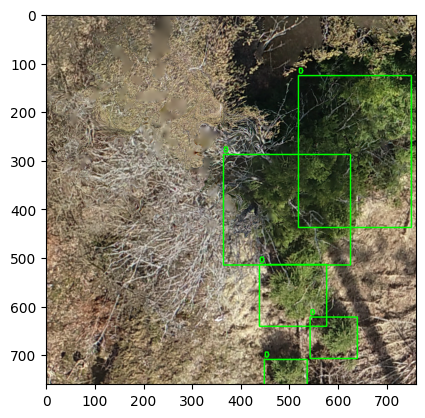

In [ ]:
# read in one of the annotation files
annotation_plot_path= glob.glob(path_to_tiles_small+"/*.txt")[6]
filename_plot=os.path.splitext(os.path.basename(annotation_plot_path))[0]
with open(annotation_plot_path, "r") as f:
    annotations = f.readlines()

# read in the corresponding image tile
image_tile_plot  = cv2.imread(path_to_tiles_small+"/"+filename_plot+".tif")

# Parse annotations
annotations = [annotation.strip().split() for annotation in annotations]
annotations = [(annotation[0], float(annotation[1]), float(annotation[2]), float(annotation[3]), float(annotation[4])) for annotation in annotations]

# Overlay annotations on image
for annotation in annotations:
    label, x, y, w, h = annotation
    x1 = int((x - w/2) * image_tile_plot.shape[1])
    y1 = int((y - h/2) * image_tile_plot.shape[0])
    x2 = int((x + w/2) * image_tile_plot.shape[1])
    y2 = int((y + h/2) * image_tile_plot.shape[0])
    cv2.rectangle(image_tile_plot, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image_tile_plot, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Plot image
plt.imshow(cv2.cvtColor(image_tile_plot, cv2.COLOR_BGR2RGB))
plt.show()

# The End 👍